In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import datetime
import re
import cvxpy as cp
import warnings

plt.rcParams["figure.figsize"] = [21, 10] 
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'


warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [0]:
path = "/content/drive/My Drive/AMS Smart Energy/data/HomeF-meter3_2016.csv"
df_meter = pd.read_csv(path, float_precision='round_trip')

In [0]:
df_meter.shape

(503925, 10)

In [0]:
df_meter.drop_duplicates('Date & Time', inplace = True)
df_meter['Date & Time'] = pd.to_datetime(df_meter['Date & Time'])

In [0]:
df_meter.loc[df_meter['Date & Time'] == '2016-01-11 00:30:00']

,Date & Time,Usage [kW],Generation [kW],Net_Meter [kW],Volt [kW],Garage_E [kW],Garage_W [kW],Phase_A [kW],Phase_B [kW],Solar [kW]
14430,2016-01-11 00:30:00,1.439517,0.0114,1.450917,0.002167,0.0,0.00035,0.15355,1.285967,0.0114


In [6]:
df_meter = df_meter['Usage [kW]']
df_meter=df_meter[14430:(14430+672)]
len(df_meter)

672

In [0]:
backup = df_meter

In [0]:
df_meter.index = np.arange(1, len(df_meter) + 1)

In [0]:
def plot_graph_offline(prov_type, x):
  plt.title("Actual vs Optimal values for Offline " + prov_type + " provisioning")
  plt.plot(x, 'b', label="Optimal Values")
  plt.plot(df_meter, 'r', label="True Values")
  plt.legend()
  plt.ylabel("Electricity Units in kW")
  plt.xlabel("Time step t(1 unit = 15 minutes)")

In [0]:
#Store algorithms, optimal values and decision values for objective function
opt_dict = {}
decision_dict = {}

# OFFLINE STATIC OPTIMIZATION

In [0]:
def offline_static_provision(df, verbose):
  p = 0.4/2
  a = 4/2
  b = 4/2
  y = df.to_list()
  x = cp.Variable(1)

  cost = p*x + a*cp.maximum(0, y - x)
  objective = cp.Minimize(cp.sum(cost) + b*x)
  constraints = [0 <= x]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = pd.Series(np.full((672), x.value), index=df.index)
  opt_dict['Offline Static'] = result
  decision_dict['Offline Static'] = opt

  if (verbose == True):
    print("\nThe optimal value is", result)
    print("The optimal x is")
    print(x.value)
    plot_graph_offline('static', opt)
  else:
    return opt


The optimal value is 396.68043326478033
The optimal x is
[1.601]


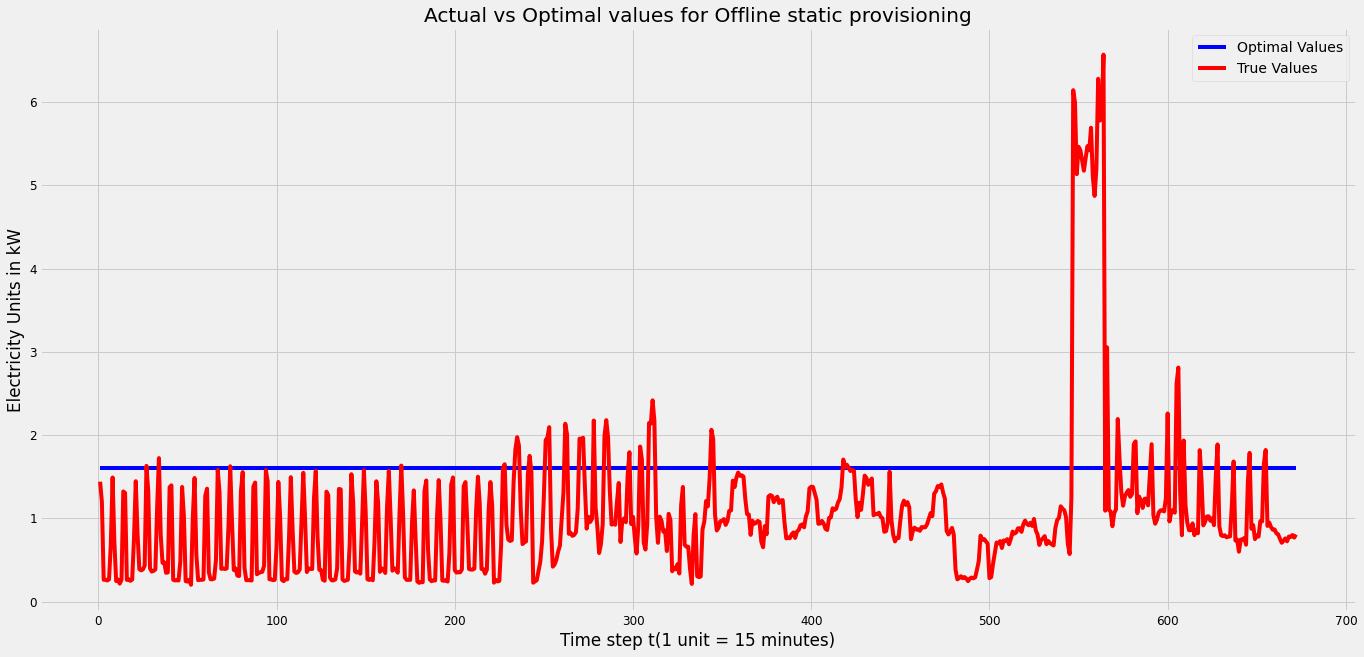

In [14]:
offline_static_provision(df_meter, True)

Thus as shown above, the static offline optimization gives the value of 1.601 kW and the objective function cost as 396.680. Since this is static optimization, we get a straight line as optimal on graph as above.

# OFFLINE DYNAMIC OPTIMIZATION

In [0]:
def offline_dynamic_provision(df, verbose):
  p = 0.4/2
  a = 4/2
  b = 4/2
  y = df.to_list()
  x = cp.Variable(672)
  cost = 0

  for i in range(1,672):
      cost += p*x[i] + a*cp.maximum(0, y[i-1] - x[i]) + b*cp.abs(x[i]-x[i-1])
  
  objective = cp.Minimize(cost)
  constraints = [x[0] == 0, x[1:] >= 0]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = pd.Series(np.array(x.value), index=df.index)
  opt_dict['Offline Dynamic'] = result
  decision_dict['Offline Dynamic'] = opt

  if (verbose == True):
    print("\nThe optimal value is", result)
    print("First 15 optimal values of x is")
    print(x.value[0:15])
    plot_graph_offline('dynamic', opt)
  else:
    return opt


The optimal value is 259.53786666387776
First 15 optimal values of x is
[-6.74089802e-16  1.36829643e+00  1.36829643e+00  1.36829643e+00
  1.36829643e+00  1.36829643e+00  1.36829643e+00  1.36829643e+00
  1.36829643e+00  1.36829643e+00  1.36829643e+00  1.36829643e+00
  1.36829643e+00  1.36829643e+00  1.36829643e+00]


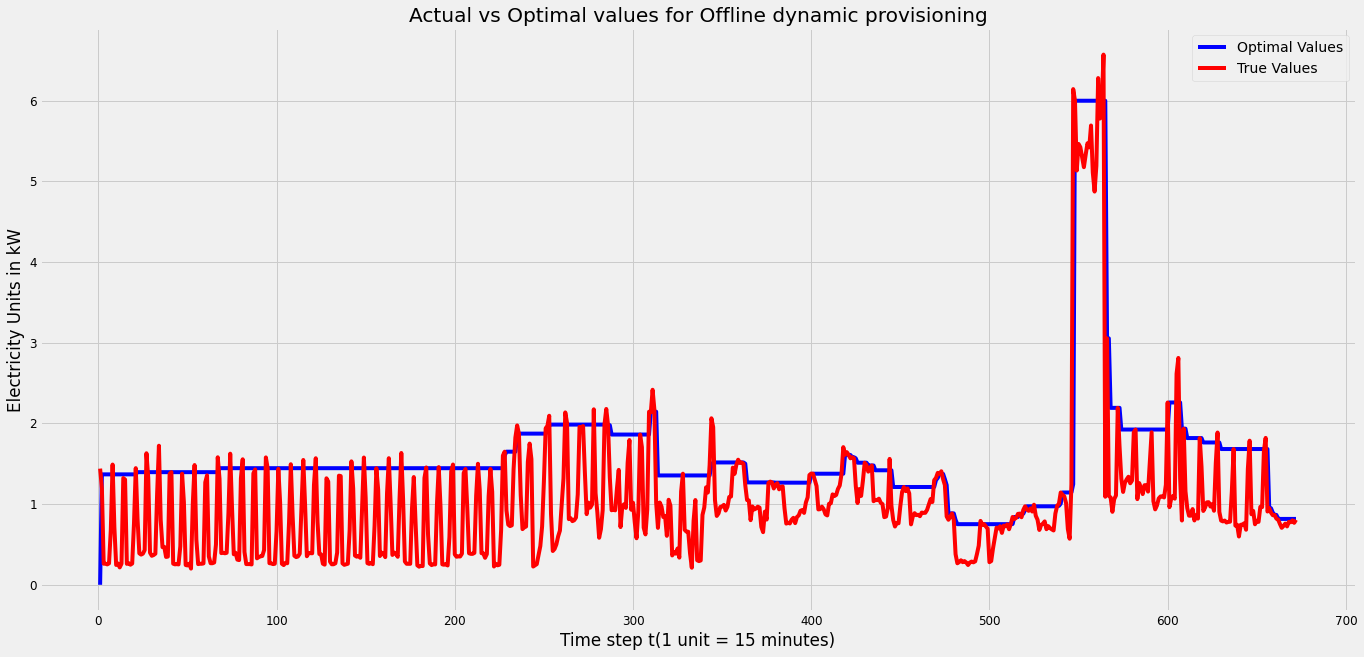

In [16]:
offline_dynamic_provision(df_meter, True)

Thus as shown above, the static offline optimization different values of x for each time step and the objective function cost as 259.53 which is less than the static one. Since this is dynamic optimization, we get a boxed line as optimal on graph as above.

# ONLINE GRADIENT DESCENT

In [0]:
def cost(method, x, y, verbose):
    cost = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for i in range(1, len(y) + 1):
        cost += p * x[i] + a * max(0, y[i] - x[i] + b * abs(x[i] - x[i - 1]))
    if (verbose == True):                         
      print("\nThe objective value for " + method + " is", cost)
    else:
      return cost

In [0]:
def gradient(x, y, t, p, a, b):
    slope = 0

    if (y[t] > x[t]):
        if (x[t] > x[t - 1]):
            slope = p - a + b;
        else:
            slope = p - a - b;
    else:
        if (x[t] > x[t - 1]):
            slope = p + b;
        else:
            slope = p - b;
    return slope;

In [0]:
def online_gradient_descent(y, steps):
    n = len(y)
    x = [0.0] * (n + 1)
    x[1] = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for t in range(1, n):
        x[t + 1] = x[t] - steps * gradient(x, y, t, p, a, b)
    return x

In [0]:
x = online_gradient_descent(df_meter, steps = 0.2)

In [0]:
cost('Online Gradient Descent', x, df_meter, True)


The objective value for Online Gradient Descent is 730.9889333260045


In [0]:
costs = []
steps = []
step = 0
for i in range(1000):
    step += 0.0001
    x = online_gradient_descent(df_meter, steps = step)
    steps.append(step)
    costs.append(cost("Cost", x ,df_meter, False))

Text(0.5, 0, 'Step Size')

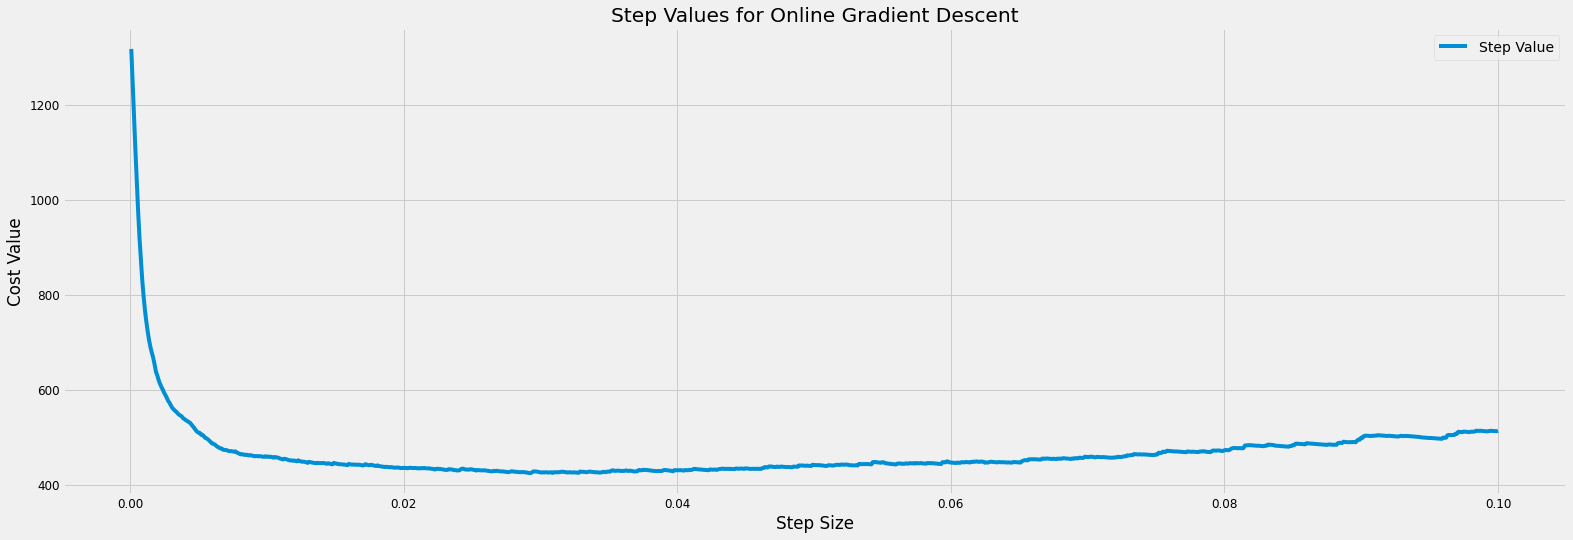

In [0]:
fig = plt.figure(figsize=(24, 8))
plt.title("Step Values for Online Gradient Descent")
plt.plot(steps, costs, label = "Step Value")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("Step Size")

The graph above shows the variation of objective function value w.r.t the step size. Initially, the cost is higher but it falls drastically later and becomes the least at step size of 0.029. After this, the objective function value again increases gradually.

In [0]:
steps[costs.index(min(costs))]

0.029299999999999878

In [21]:
x = online_gradient_descent(df_meter, steps = steps[costs.index(min(costs))])
print("Optimal cost found at step: ", steps[costs.index(min(costs))])
print("\nOptimal cost is:")
print(cost("Online Gradient Descent", x, df_meter, True))
opt_dict['OGD'] = cost("Online Gradient Descent", x, df_meter, False)
decision_dict['OGD'] = x

Optimal cost found at step:  0.029299999999999878

Optimal cost is:

The objective value for Online Gradient Descent is 424.09634133200024
None


Text(0.5, 0, 'Time step t(1 unit = 15 minutes)')

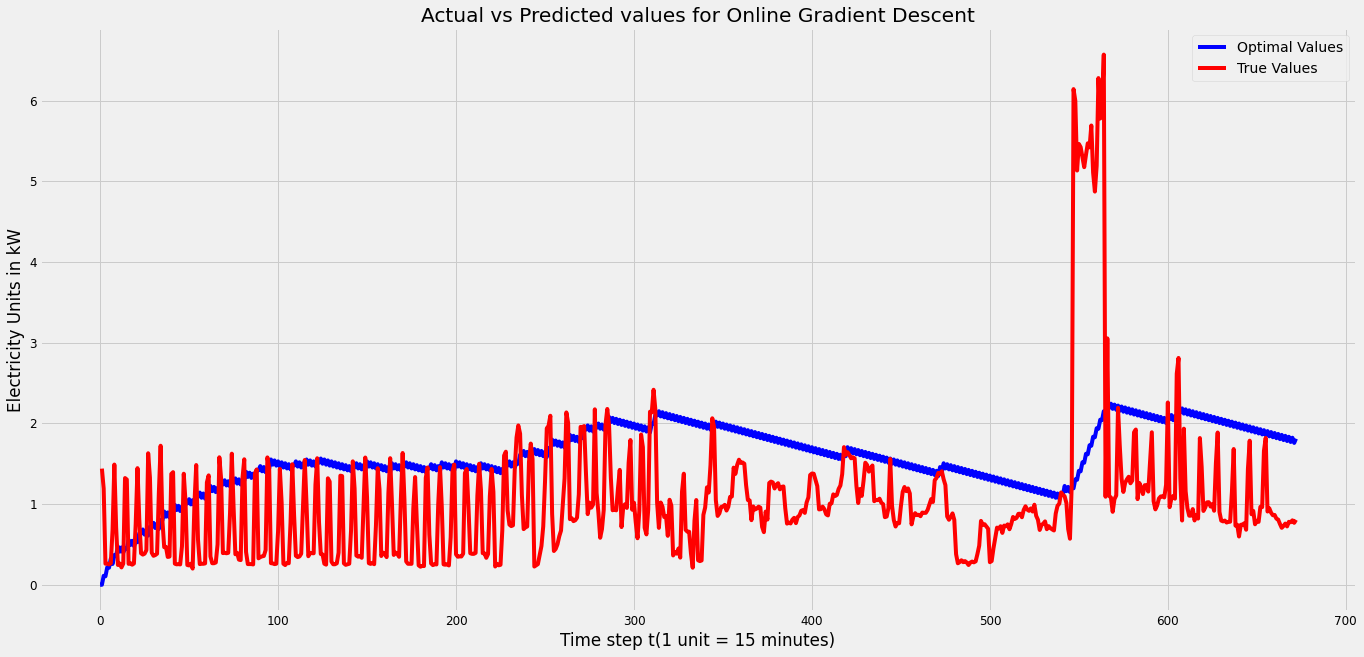

In [0]:
plt.title("Actual vs Predicted values for Online Gradient Descent")
plt.plot(x, 'b', label="Optimal Values")
plt.plot(df_meter, 'r', label="True Values")
plt.legend()
plt.ylabel("Electricity Units in kW")
plt.xlabel("Time step t(1 unit = 15 minutes)")

Thus as shown above, the online gradient descent optimization gives different values of x for each time step T and the least objective function cost 424.09 is obtained at step size 0.029.

Text(0.5, 0, 'Time step t(1 unit = 15 minutes)')

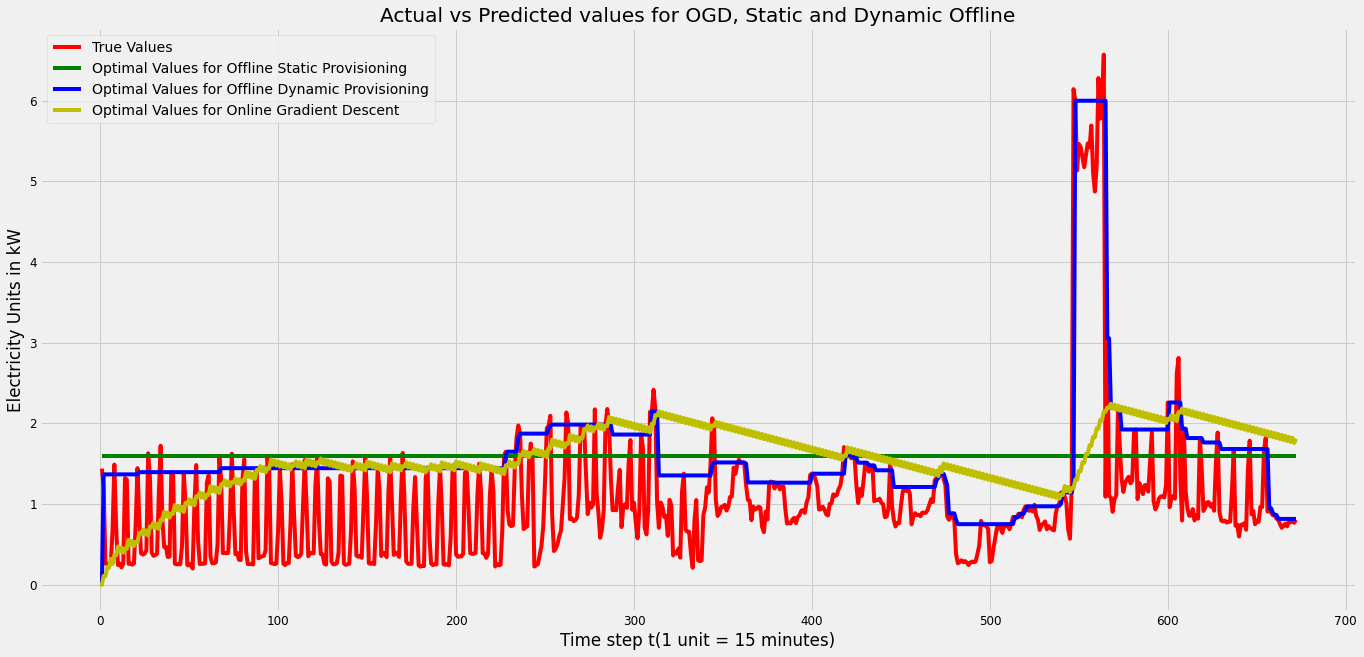

In [0]:
plt.title("Actual vs Predicted values for OGD, Static and Dynamic Offline")
plt.plot(df_meter, 'r', label="True Values")
plt.plot(offline_static_provision(df_meter, False), 'g', label="Optimal Values for Offline Static Provisioning")
plt.plot(offline_dynamic_provision(df_meter, False), 'b', label="Optimal Values for Offline Dynamic Provisioning")
plt.plot(x, 'y', label="Optimal Values for Online Gradient Descent")
plt.legend()
plt.ylabel("Electricity Units in kW")
plt.xlabel("Time step t(1 unit = 15 minutes)")

The above graph shows the comparison of provisioning by Static Offline, Dynamic Offline and OGD algorithms agains the actual values. As discussed in lecture, the optimal values for Online Gradient Descent converges with the optimal value for Static Offline Provisioning but they don’t converge with Dynamic Offline Provisioning values.

In [0]:
decision_dict['Actual'] = df_meter

In [0]:
path = "/content/drive/My Drive/AMS Smart Energy/data/prediction_results_F_extratrees.csv"
y_extratrees = pd.read_csv(path, usecols = ['prediction'])

# RHC and CHC with ExtraTrees and XGBoost for fixed value of a and b

XGBoost and ExtraTrees were found out to be the best algorithms for House B for prediction in Assignment 1. Following section describes use of RHC and CHC with both of them separately

In [0]:
def RHC(y, predictionHorizon, prediction_algo):
  T = 2*24*14;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    optValues[horizonStart] = x.value[0];

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])
  
  opt_dict['RHC' + '_' + prediction_algo] = obj
  decision_dict['RHC' + '_' + prediction_algo] = optValues

  return obj

In [0]:
RHC(y_extratrees['prediction'].to_numpy(), 5, 'ExtraTrees')

721.7067009691549

In [0]:
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(RHC(y_extratrees['prediction'].to_numpy(), i, 'ExtraTrees'))

Text(0.5, 0, 'Prediction Window Size')

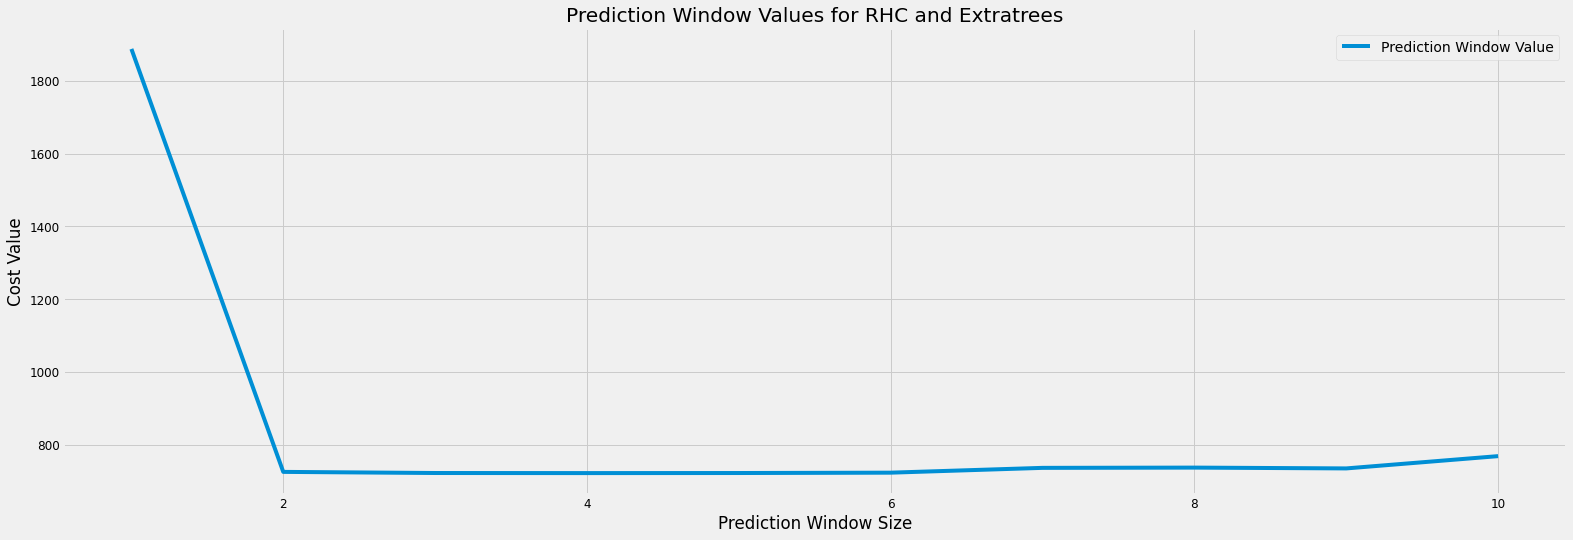

In [0]:
fig = plt.figure(figsize=(24, 8))
plt.title("Prediction Window Values for RHC and Extratrees")
plt.plot(windows, costs, label = "Prediction Window Value")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("Prediction Window Size")

The graph above shows the variation of objective function value for combination of RHC and ExtraTrees algorithm w.r.t the prediction window size. Initially, the cost is higher but it falls drastically later and becomes the least (721.50) at window size of 4. After this, the objective function value almost remains constant.

In [26]:
x = RHC(y_extratrees['prediction'].to_numpy(), windows[costs.index(min(costs))], 'ExtraTrees')
print("Optimal cost for RHC and extratrees found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)

Optimal cost for RHC and extratrees found at window size:  4

Optimal cost is:  721.501123545677


# RHC with XGBoost

In [0]:
path = "/content/drive/My Drive/AMS Smart Energy/data/prediction_results_F_xgboost.csv"
y_svr = pd.read_csv(path, usecols = ['prediction'])

In [0]:
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(RHC(y_svr['prediction'].to_numpy(), i, 'XGBoost'))

Text(0.5, 0, 'Prediction Window Size')

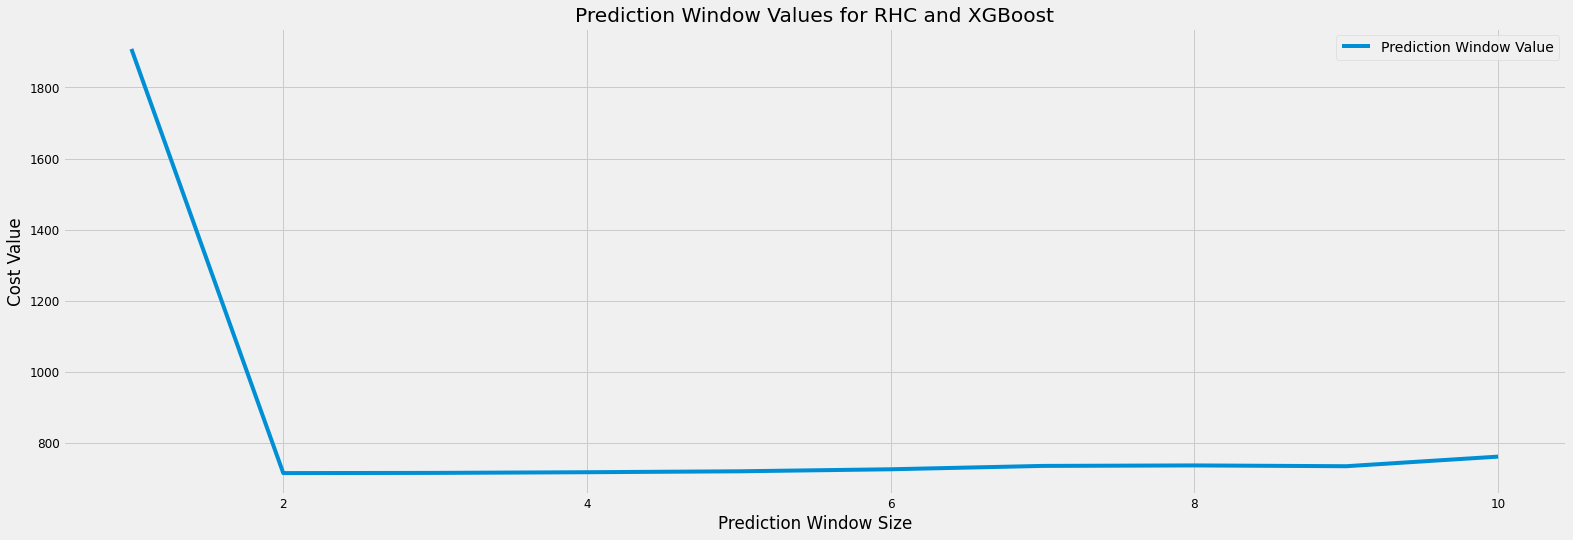

In [0]:
fig = plt.figure(figsize=(24, 8))
plt.title("Prediction Window Values for RHC and XGBoost")
plt.plot(windows, costs, label = "Prediction Window Value")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("Prediction Window Size")

The graph above shows the variation of objective function value for combination of RHC and XGBoost algorithm w.r.t the prediction window size. Initially, the cost is higher but it falls drastically later and becomes the least (715.285) at window size of 2. After this, the objective function value almost remains constant.

In [29]:
x = RHC(y_svr['prediction'].to_numpy(), windows[costs.index(min(costs))], 'XGBoost')
print("Optimal cost for RHC and XGBoost found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)

Optimal cost for RHC and XGBoost found at window size:  2

Optimal cost is:  715.28529378443


# CHC with ExtraTrees and XGBoost

In [0]:
def CHC(y, predictionHorizon, commitmentHorizon, prediction_algo):
  T = 2*24*14;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  opt_dict['CHC' + '_' + prediction_algo] = obj
  decision_dict['CHC' + '_' + prediction_algo] = optValues

  return obj

In [0]:
CHC(y_extratrees['prediction'].to_numpy(), 10, 1, 'ExtraTrees')

768.1253801002368

# CHC with ExtraTrees

In [0]:
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(CHC(y_extratrees['prediction'].to_numpy(), 10, i, 'ExtraTrees'))

Text(0.5, 0, 'Commitment Horizon Size')

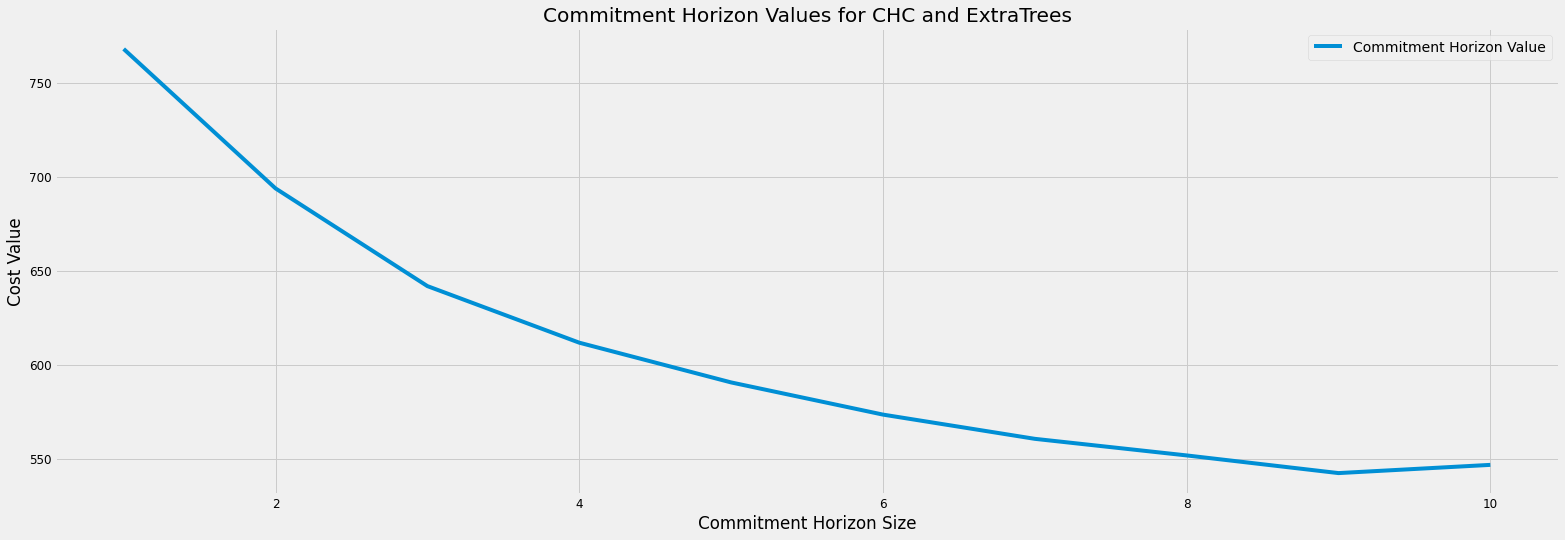

In [0]:
fig = plt.figure(figsize=(24, 8))
plt.title("Commitment Horizon Values for CHC and ExtraTrees")
plt.plot(windows, costs, label = "Commitment Horizon Value")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("Commitment Horizon Size")

The graph above shows the variation of objective function value for combination of CHC and ExtraTrees algorithm w.r.t the commitment horizon size. Initially, the cost is higher but it falls gradually later and becomes the least (542.40) at commitment horizon size of 9. After this, the objective function value increases again.

In [32]:
x = CHC(y_extratrees['prediction'].to_numpy(), 10, windows[costs.index(min(costs))], 'ExtraTrees')
print("Optimal cost for CHC found at commitment horizon size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)

Optimal cost for CHC found at commitment horizon size:  9

Optimal cost is:  542.4072648762576


# CHC with XGBoost

In [0]:
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(CHC(y_svr['prediction'].to_numpy(), 10, i, 'XGBoost'))

Text(0.5, 0, 'Commitment Horizon Size')

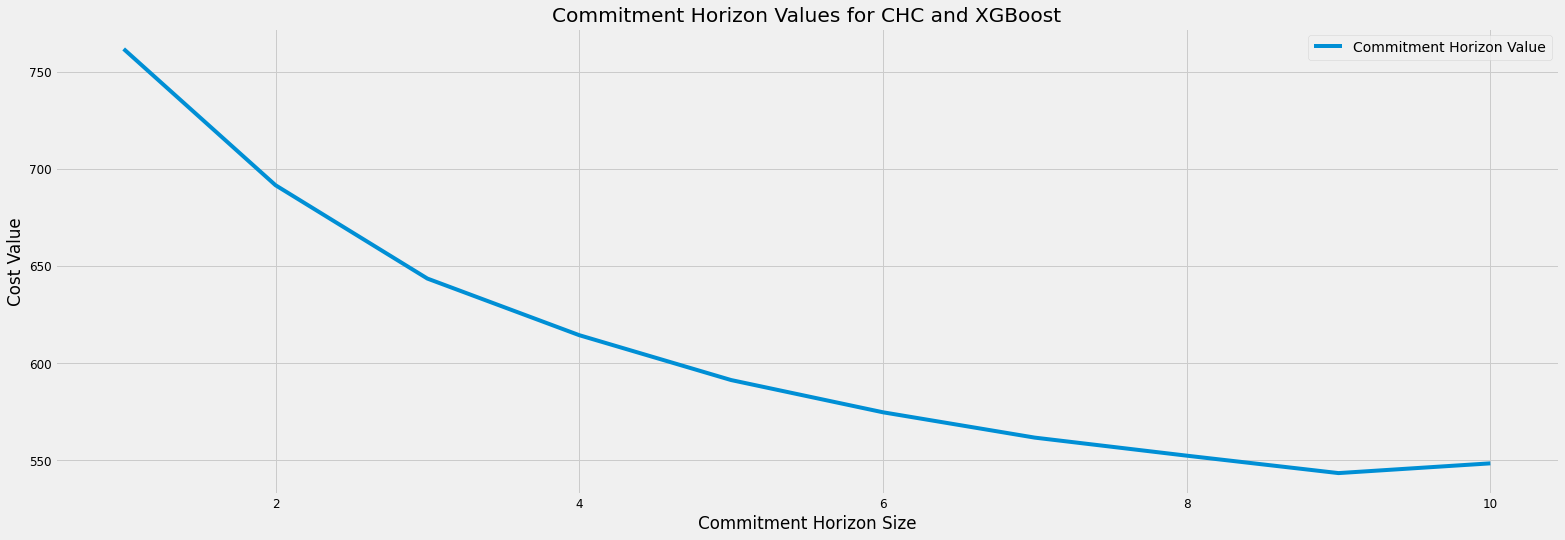

In [0]:
fig = plt.figure(figsize=(24, 8))
plt.title("Commitment Horizon Values for CHC and XGBoost")
plt.plot(windows, costs, label = "Commitment Horizon Value")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("Commitment Horizon Size")

The graph above shows the variation of objective function value for combination of CHC and XGBoost algorithm w.r.t the commitment horizon size. Initially, the cost is higher but it falls gradually later and becomes the least (543.40) at commitment horizon size of 9. After this, the objective function value almost remains constant.

In [34]:
x = CHC(y_svr['prediction'].to_numpy(), 10, windows[costs.index(min(costs))], 'XGBoost')
print("Optimal cost for CHC and XGBoost found at commitment horizon size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)

Optimal cost for CHC and XGBoost found at commitment horizon size:  9

Optimal cost is:  543.4041487741924


# Comparison of OGD, CHC, RHC with Static Offline and Dynamic Offline Algorithms

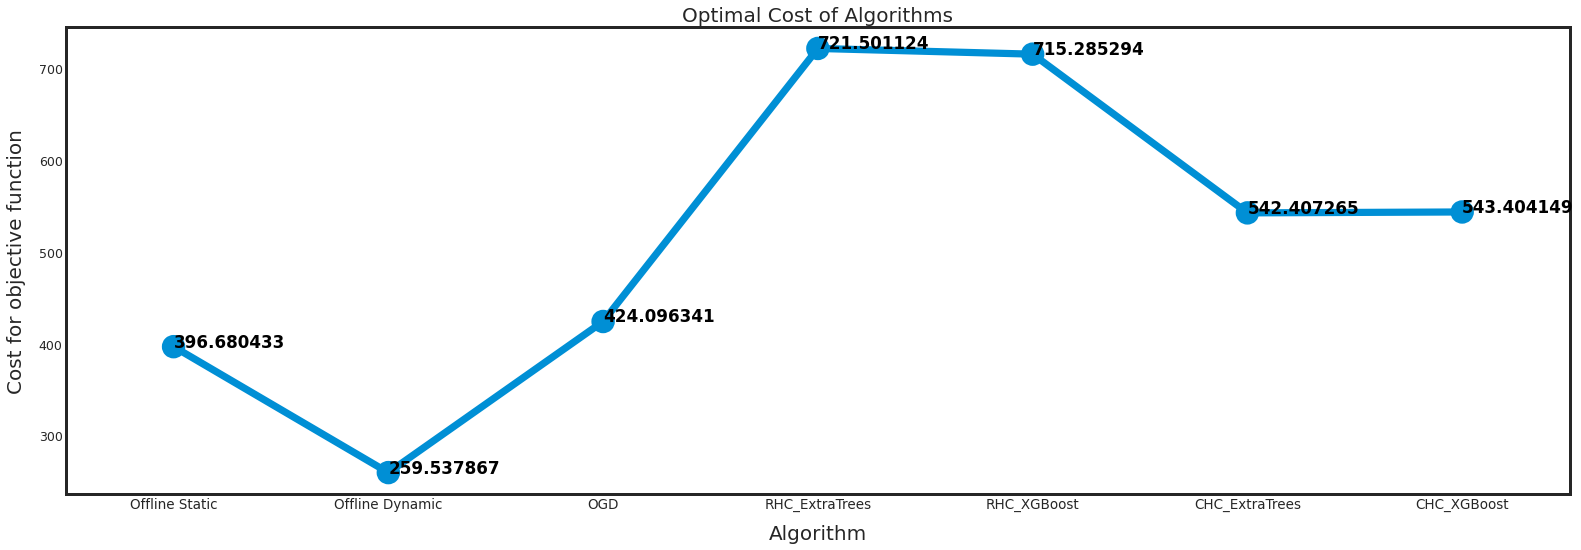

In [0]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 8))

ax = sns.pointplot(x=list(opt_dict.keys()), y=[score for score in opt_dict.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(opt_dict.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Cost for objective function', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Optimal Cost of Algorithms', size=20)

plt.show()

The above graph compares the objective function value for Offline Static and Dynamic, OGD, RHC with ExtraTrees, RHC with XGBoost, CHC with ExtraTrees, CHC with XGBoost. RHC with ExtraTrees preforms the worst while Offline Dynamic Provisioning preforms the best. Lower the values, higher the preformance and better the accuracy.

In [0]:
static_obj = opt_dict.pop('Offline Static')
dynamic_obj = opt_dict.pop('Offline Dynamic')

static_dict = {}
for key in opt_dict:
  static_dict[key] = opt_dict[key] - static_obj

dynamic_dict = {}
for key in opt_dict:
  dynamic_dict[key] = opt_dict[key] - dynamic_obj

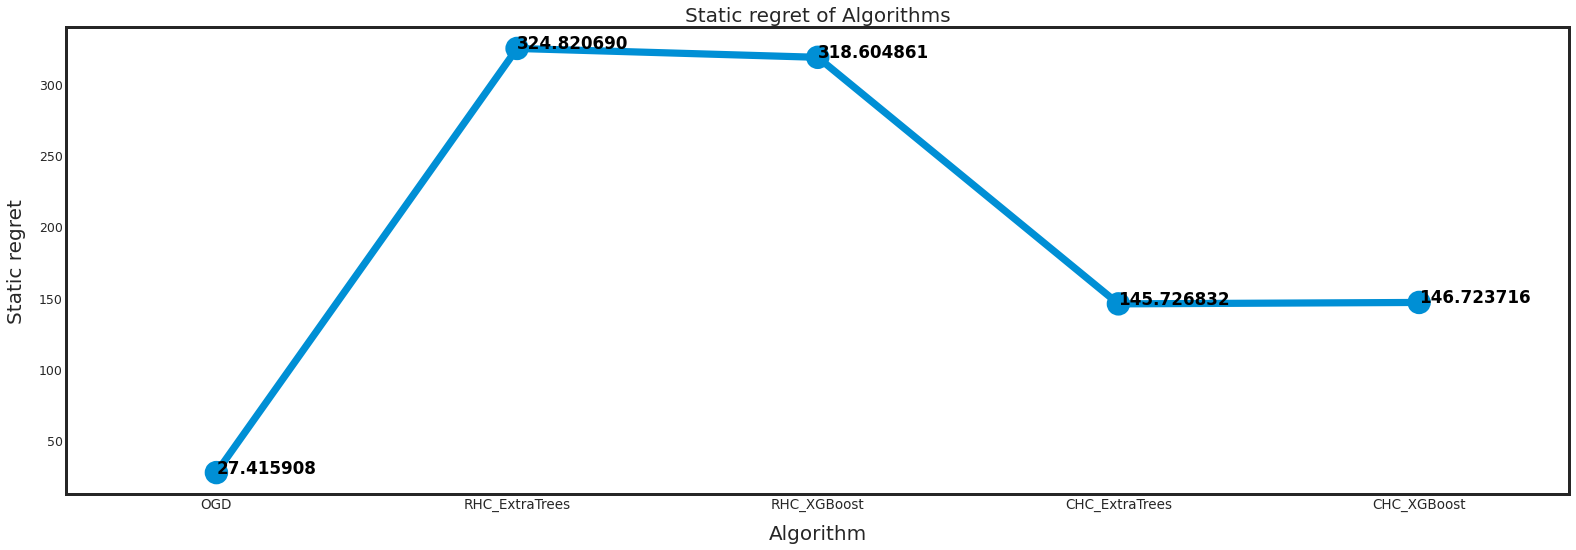

In [36]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 8))

ax = sns.pointplot(x=list(static_dict.keys()), y=[score for score in static_dict.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(static_dict.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Static regret', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Static regret of Algorithms', size=20)

plt.show()

Thus, all algorithms have a positive static regret meaning all of them perform bad than static optimal.

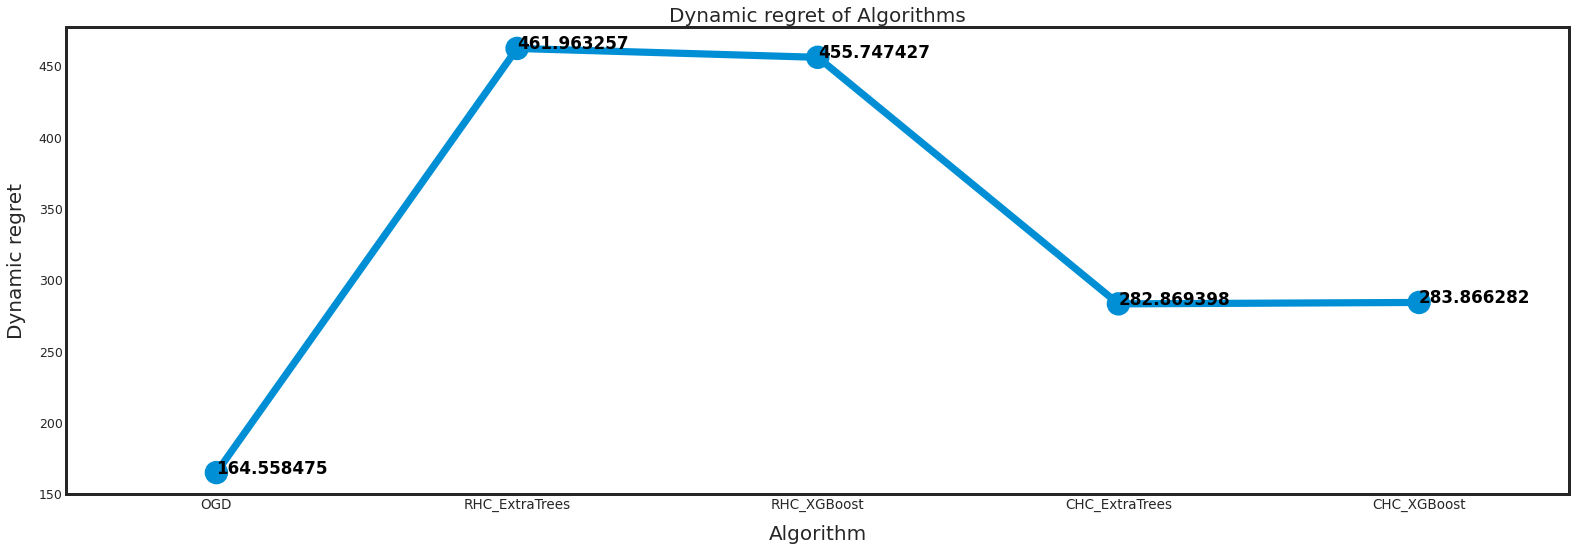

In [37]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 8))

ax = sns.pointplot(x=list(dynamic_dict.keys()), y=[score for score in dynamic_dict.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(dynamic_dict.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Dynamic regret', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Dynamic regret of Algorithms', size=20)

plt.show()

Thus all agorithms have a positive dynamic regret meaning dynamic optimal performs better than all. OGD has least positive regret.

Text(0.5, 0, 'Time step t(1 unit = 15 minutes)')

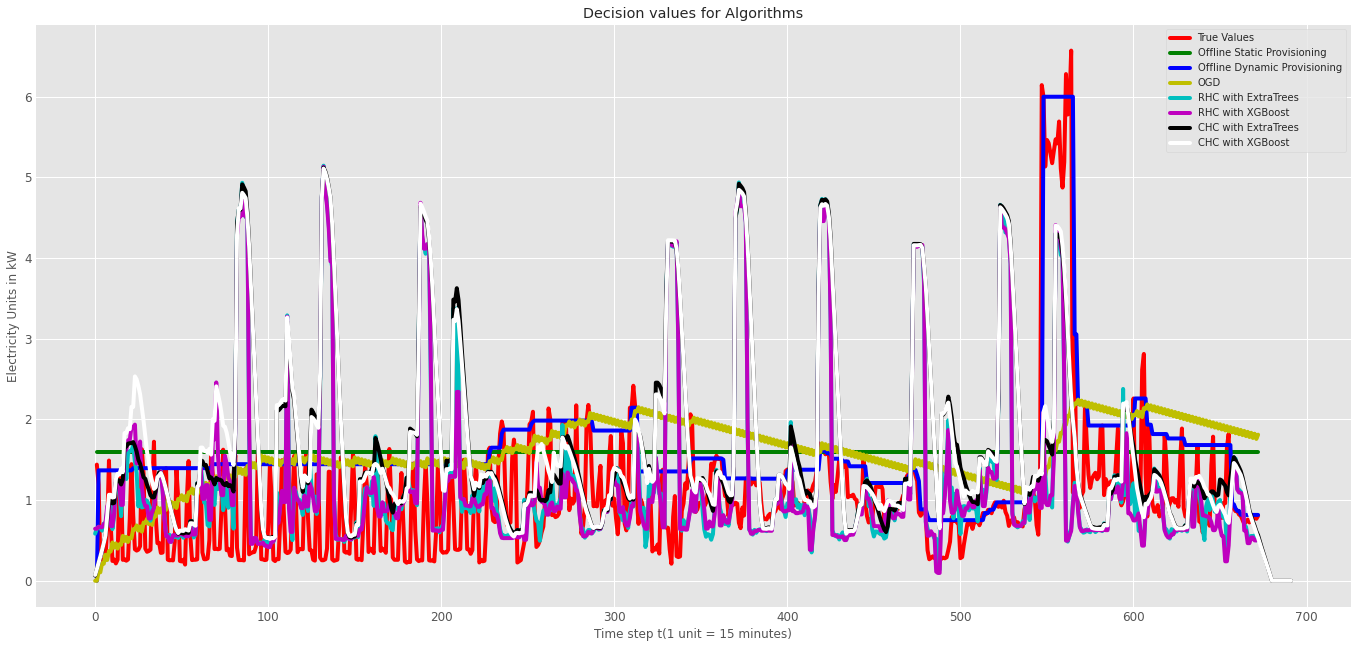

In [0]:
plt.style.use('ggplot')
plt.title("Decision values for Algorithms")
plt.plot(df_meter, 'r', label="True Values")
plt.plot(decision_dict['Offline Static'], 'g', label="Offline Static Provisioning")
plt.plot(decision_dict['Offline Dynamic'], 'b', label="Offline Dynamic Provisioning")
plt.plot(decision_dict['OGD'], 'y', label="OGD")
plt.plot(decision_dict['RHC_ExtraTrees'], 'c', label="RHC with ExtraTrees")
plt.plot(decision_dict['RHC_XGBoost'], 'm', label="RHC with XGBoost")
plt.plot(decision_dict['CHC_ExtraTrees'], 'k', label="CHC with ExtraTrees")
plt.plot(decision_dict['CHC_XGBoost'], 'w', label="CHC with XGBoost")
plt.legend()
plt.ylabel("Electricity Units in kW")
plt.xlabel("Time step t(1 unit = 15 minutes)")

The above graph plots provisions by 7 different algorithms with the actual consumption values.

# Varying a and b for the best combination of control algorithm and prediction algorithm

Best combination is CHC with ExtraTrees with commitment horizon size of 9 with a=4 and b=4. We keep commitment horizon size as constant and vary first a by keeping b constant and then vice-versa to see the impact of change.

In [0]:
def chc_vary_and_b(y, predictionHorizon, commitmentHorizon, prediction_algo, a, b):
  T = 2*24*14;
  p = 0.4/2;
  a = a/2;
  b = b/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

In [0]:
costs = []
windows = []
b = 4
for i in range(1,11):
    windows.append(i)
    costs.append(chc_vary_and_b(y_extratrees['prediction'].to_numpy(), 10, 9, 'ExtraTrees', i, b))

Text(0.5, 0, 'a')

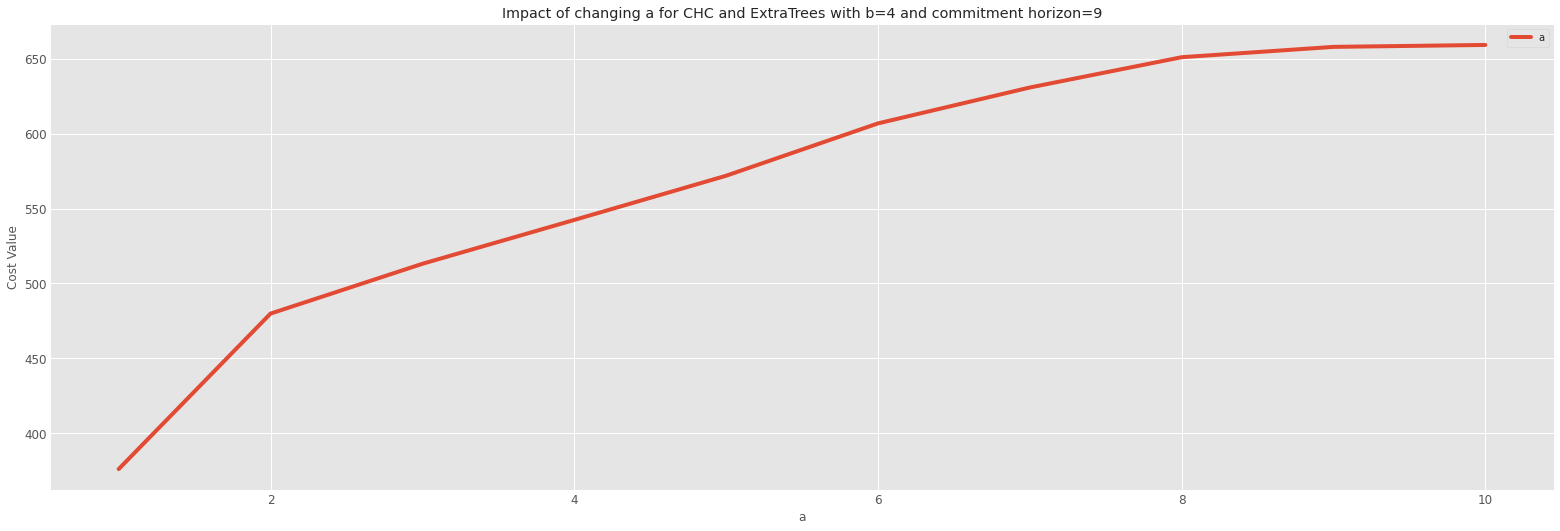

In [0]:
fig = plt.figure(figsize=(24, 8))
plt.title("Impact of changing a for CHC and ExtraTrees with b=4 and commitment horizon=9")
plt.plot(windows, costs, label = "a")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("a")

The above graph shows the impact of changing values for a for combination of CHC and ExtraTrees with commitment horizon of 9. The cost goes on increasing with increase in a.

In [0]:
costs = []
windows = []
a = 4
for i in range(1,11):
    windows.append(i)
    costs.append(chc_vary_and_b(y_extratrees['prediction'].to_numpy(), 10, 9, 'ExtraTrees', a, i))

Text(0.5, 0, 'b')

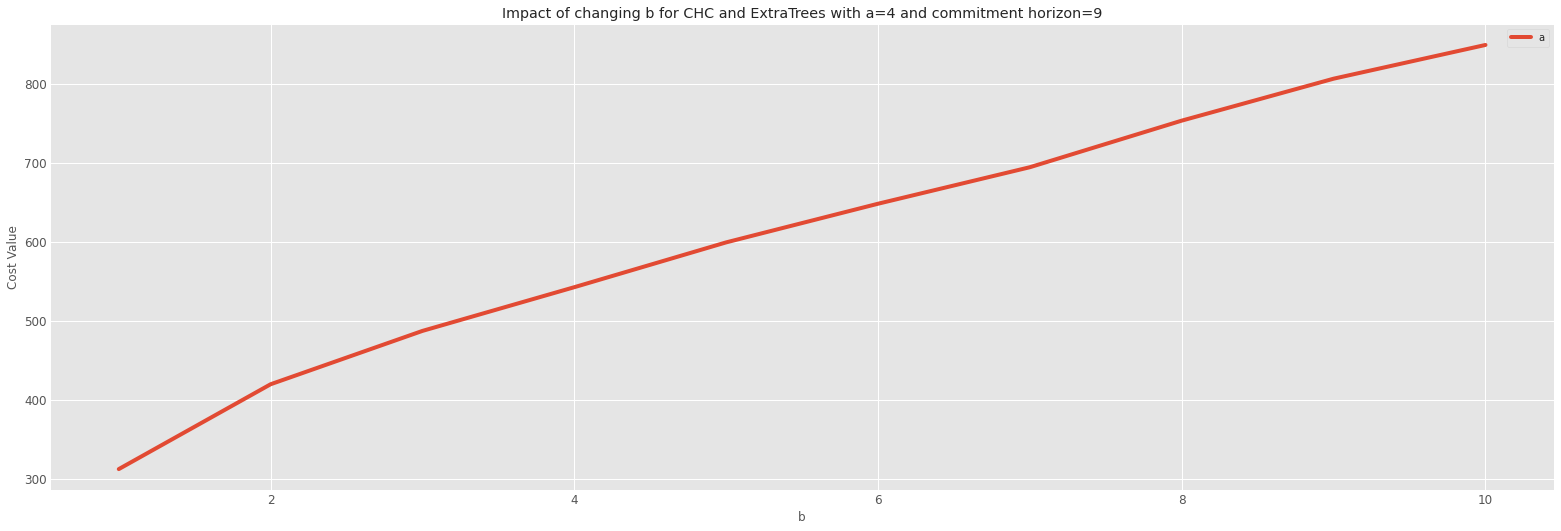

In [0]:
fig = plt.figure(figsize=(24, 8))
plt.title("Impact of changing b for CHC and ExtraTrees with a=4 and commitment horizon=9")
plt.plot(windows, costs, label = "a")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("b")

The above graph shows the impact of changing values for b for combination of CHC and ExtraTrees with commitment horizon of 9. The cost goes on increasing with increase in b.

# Algorithm Selection

In order to select the best algorithm out of multiple algorithms for online convex optimization, there should be constant performance criteria for all of them. I decided to use dynamic regret factor as the evaluation criteria. For each of the algorithms, we minimize the objective function.

In [0]:
def online_gradient_descent_fixed_window(y, steps):
    n = 4
    x = [0.0] * (n + 1)
    x[1] = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for t in range(1, n):
      if (y[t] > x[t]):
          if (x[t] > x[t - 1]):
              slope = p - a + b;
          else:
              slope = p - a - b;
      else:
          if (x[t] > x[t - 1]):
              slope = p + b;
          else:
              slope = p - b;
      x[t + 1] = x[t] - steps * slope
    return x

In [0]:
def rhc_fixed_window(y, predictionHorizon, prediction_algo):
  T = 4;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    optValues[horizonStart] = x.value[0];

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

In [0]:
def chc_fixed_window(y, predictionHorizon, commitmentHorizon, prediction_algo):
  T = 4;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

In [0]:
def cost_fixed_window(x, y):
    cost = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for i in range(1, 5):
        cost += p * x[i] + a * max(0, y[i] - x[i] + b * abs(x[i] - x[i - 1]))
   
    return cost

In [0]:
def offline_dynamic_provision_fixed_window(y):
  p = 0.4/2
  a = 4/2
  b = 4/2
  x = cp.Variable(4)
  cost = 0

  for i in range(1,4):
      cost += p*x[i] + a*cp.maximum(0, y[i-1] - x[i]) + b*cp.abs(x[i]-x[i-1])
  
  objective = cp.Minimize(cost)
  constraints = [x[0] == 0, x[1:] >= 0]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = np.array(x.value)
  opt = np.insert(opt, 0, 0., axis=0)
  
  return opt

# Deterministic Approach

The algorithm followed in the Deterministic approach is as follows:

1)Select a fixed window size(eg. 4) and step size(eg. 4)
2)Iterate over entire time horizon (T=672) with step size = window size.
3)In each window, evaluate objective function value for each of the algorithms.
4)The algorithm which give the cost value closest to the cost value givenby offline dynamic algorithm wins that round/window. 5)An account of the number of times each algorithm won is maintained.
6)At the end, the algorithm with highest number of wins is declared the winner.

In [0]:
import operator

def deterministic():
  win_ogd = 0;
  win_rhc = 0;
  win_chc = 0;
  obj_diff_dict = {}
  y = y_extratrees['prediction'].to_numpy()
  for i in range(1, 673):
    obj_ogd = cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])
    obj_rhc = rhc_fixed_window(y[i:], 4, 'ExtraTrees')
    obj_chc = chc_fixed_window(y[i:], 10, 9, 'ExtraTrees')
    obj_offline_dynamic = cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_diff_dict['OGD'] = abs(obj_offline_dynamic - obj_ogd)
    obj_diff_dict['RHC'] = abs(obj_offline_dynamic - obj_rhc)
    obj_diff_dict['CHC'] = abs(obj_offline_dynamic - obj_chc)
    optimal_algo = min(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    
    if optimal_algo == 'OGD':
      win_ogd += 1
    elif optimal_algo == 'RHC':
      win_rhc += 1
    else:
      win_chc += 1

  obj_win_dict = {}
  obj_win_dict['OGD'] = win_ogd
  obj_win_dict['RHC'] = win_rhc
  obj_win_dict['CHC'] = win_chc
  print(obj_win_dict)
  return max(obj_win_dict.items(), key=operator.itemgetter(1))[0]


In [0]:
print('The winner for deterministic approach is: ',deterministic())

{'OGD': 196, 'RHC': 26, 'CHC': 450}
The winner for deterministic approach is:  CHC


As seen above, out of 672 windows, CHC wins the most number of times(450) and RHC the least(26). Thus, CHC is the winner.

# Randomized Approach

The algorithm followed in the Randomized approach is as follows:

1)Assign equal weights to each algorithm at the start
2) Pick a window size say 4
3)Iterate over entire time horizon (T=672).
4)In each window, evaluate objective function value for each of the
algorithms.
5)Increase the weight of algorithm with least difference with objective function value of offline dynamic by 0.0005 and decrease the weight of the algorithm with max difference by 0.0005.
6)At the end, we get final weights of all algorithms which can be used to make a decision.

In [0]:
import math

def randomized():
  wt_ogd = 1/3;
  wt_rhc = 1/3;
  wt_chc = 1/3;
  obj_diff_dict = {}
  y = y_extratrees['prediction'].to_numpy()

  for i in range(1, 673):
    obj_ogd = cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])
    obj_rhc = rhc_fixed_window(y[i:], 4, 'ExtraTrees')
    obj_chc = chc_fixed_window(y[i:], 10, 9, 'ExtraTrees')
    obj_offline_dynamic = cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_diff_dict['OGD'] = abs(obj_offline_dynamic - obj_ogd)
    obj_diff_dict['RHC'] = abs(obj_offline_dynamic - obj_rhc)
    obj_diff_dict['CHC'] = abs(obj_offline_dynamic - obj_chc)
    most_optimal_algo = min(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    least_optimal_algo = max(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    
    
    if i > 1:
      if most_optimal_algo == 'OGD':
        wt_ogd += 0.0005
      elif most_optimal_algo == 'RHC':
        wt_rhc += 0.0005
      else:
        wt_chc += 0.0005

      if least_optimal_algo == 'OGD':
        wt_ogd -= 0.0005
      elif least_optimal_algo == 'RHC':
        wt_rhc -= 0.0005
      else:
        wt_chc -= 0.0005

    last_winner = most_optimal_algo
    last_loser = least_optimal_algo

  obj_wt_dict = {}
  obj_wt_dict['OGD'] = wt_ogd
  obj_wt_dict['RHC'] = wt_rhc
  obj_wt_dict['CHC'] = wt_chc
  print('The final weights for randomized approach is: ', obj_wt_dict)


In [0]:
randomized()

The final weights for randomized approach is:  {'OGD': 0.4143333333333334, 'RHC': 0.04433333333333306, 'CHC': 0.5413333333333289}


The final weights obtained by Randomized approach is 0.41 for OGD, 0.05 for RHC and 0.54 for CHC.

In [0]:
def compare():
  y = y_extratrees['prediction'].to_numpy()
  obj_deterministic = 0
  obj_offline_dynamic = 0
  obj_randomized = 0

  for i in range(1, 673):
    obj_deterministic += chc_fixed_window(y[i:], 10, 9, 'ExtraTrees')
    obj_offline_dynamic += cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_randomized += 0.54*chc_fixed_window(y[i:], 10, 9, 'ExtraTrees')+0.05*rhc_fixed_window(y[i:], 3, 'ExtraTrees')+0.41*cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])

  obj_dict = {}
  obj_dict['Deterministic'] = obj_deterministic
  obj_dict['Offline Dynamic'] = obj_offline_dynamic
  obj_dict['Randomized'] = obj_randomized
  print(obj_dict)
  return max(obj_dict.items(), key=operator.itemgetter(1))[0]

In [0]:
compare()

{'Deterministic': 6564.195824106133, 'Offline Dynamic': 7025.896481038117, 'Randomized': 6871.991298126321}


'Offline Dynamic'

The above part compares the objective function value for Offline Dynamic, Deterministic and Randomized approaches. If we consider Offline Dynamic as the baseline, then Randomized algorithm is the closest to it meaning it performs better.